In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
import data as da

In [2]:
import torch.distributions as dist
import torch

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score,explained_variance_score

In [5]:
# read data
data_pro=da.Data()
df=data_pro.read_data()

x,y=data_pro.split_x_y(df)
x,X_train,X_test,y_train,y_test=data_pro.data_processing(x,y,True)


## scikit learn naive bayesian classifier

In [6]:
from sklearn.naive_bayes import GaussianNB
# basic Naive bayesian from 
test_gaussian=GaussianNB()
test_gaussian.fit(X_train,y_train.ravel())

y_pred=test_gaussian.predict(X_train)



In [7]:
test_gaussian.score(X_test,y_test)

0.4418367346938776

the gaussian with naive bayesian from not make sense because it is a classifier

## Implementing Bayesian Linear Regression and Classifier

suppose 
$$\begin{align}
y_i &\sim \mathrm{Normal}(\beta^T\phi(X_i), \sigma^2)\\
\phi(X_i) &= [1,x_1,x_2,...,x_n]\\
\beta &\sim \mathrm{Normal}(0,\alpha^{-1} I)
\end{align}$$

Under this assumption, the logarithm of posterio distribution is going to be quite like the ridge regression's loss function

$$\begin{align}
\hat{\beta}_{MAP}=\mathop{\arg\max}\limits_{\beta}-\frac{1}{2\sigma^2}\sum^N_{i=1}(y_i-\beta^T\phi(x_i))^2-\frac{\alpha}{2}\beta^T\beta
\end{align}$$

we can use gradient descent to get the estimated value of $\beta$.
 The value of $\alpha$ and $\sigma$ can be assumed as any value, it will certainly make the estimation of $\beta$ different, but that is also how the ridge regression works. $\lambda\equiv\alpha\sigma^2$

In [8]:
np.delete(np.arange(5),1)

array([0, 2, 3, 4])

In [11]:
#cross validation for bayesian estimator
X_train_stacks=np.array_split(X_train,5,axis=0)
y_train_stacks=np.array_split(y_train,5,axis=0)
least_rmse=999

valid_index=0
validate_stack=X_train_stacks[valid_index]
train_stacks=np.concatenate([X_train_stacks[i] for i in np.delete(np.arange(5),valid_index)])

In [ ]:
def phi(data):
    # phi x in the formula
    return np.stack([np.append(1,x) for x in data],0)

def log_p(Phi,y,beta,alpha=torch.tensor(4),sigma=torch.tensor(.5)):
    # the logarithm of posterio distribution for the p(y,beta|x,alpha,sigma)

    N, D = Phi.shape

    log_prior=dist.MultivariateNormal(torch.zeros(D),torch.eye(D)/alpha).log_prob(beta.float())
    log_likelihood=dist.Normal(torch.matmul(torch.tensor(Phi).float(),beta.reshape(-1,1)),sigma**2).log_prob(torch.tensor(y).float()).sum()

    return log_prior+log_likelihood

In [ ]:
def mcmc_step(current_beta, Phi, y, proposal_std):
    # use Normal as a proposal, it is the criterion with which beta is moving on the markov chain, nothing to do with the prior
    proposal=dist.Normal(current_beta,proposal_std)
    candidate_beta=proposal.sample()
    
    try:
        p_new=log_p(Phi, y, current_beta, alpha, sigma)
    except ValueError:
        p_new=-torch.inf
    
    p_old=log_p(Phi, y, current_beta, alpha, sigma)
    if p_new-p_old>torch.rand(1).log().item():
#     if p_new-p_old>0:
        return candidate_beta,1
    else:
        return current_beta,0

def run_chain(Phi,y,init,num_steps, proposal_std):
    beta_chain=[init]
    accepted=0
    for step in range(num_steps):
        beta,accept=mcmc_step(beta_chain[-1],Phi, y, proposal_std)
        beta_chain.append(beta)
        accepted+=accept
    return beta_chain,accepted
    

In [23]:
for sigma in [0.1,0.25,0.5,1,2,3,4]:
    for alpha in [0.1,0.25,0.5,1,2,4]:
        lamda=alpha*sigma**2
        rmse_sum=0
        for valid_index in range(5):
            validate_stack=X_train_stacks[valid_index]
            train_stacks=np.concatenate([X_train_stacks[i] for i in np.delete(np.arange(5),valid_index)])
            ytrain_stacks=np.concatenate([y_train_stacks[i] for i in np.delete(np.arange(5),valid_index)])
            
            Phi_train=phi(train_stacks)
            beta_temp=np.linalg.inv(Phi_train.T @ Phi_train + lamda * np.eye(Phi_train.shape[1])) @ Phi_train.T @ ytrain_stacks

            ytrain_pred_temp=Phi_train @ beta_temp

            rmse_sum+=mean_squared_error(ytrain_pred_temp,ytrain_stacks)
        if rmse_sum<least_rmse:
            least_parameter={'alpha':alpha,'sigma':sigma}
            least_rmse=rmse_sum
        print('sigma: {}\nalpha: {}\nsum of 5 fold rmse: {}'.format(sigma,alpha,rmse_sum))


sigma: 0.1
alpha: 0.1
sum of 5 fold rmse: 2.6995043929590326
sigma: 0.1
alpha: 0.25
sum of 5 fold rmse: 2.6995043931242724
sigma: 0.1
alpha: 0.5
sum of 5 fold rmse: 2.6995043937143786
sigma: 0.1
alpha: 1
sum of 5 fold rmse: 2.699504396074529
sigma: 0.1
alpha: 2
sum of 5 fold rmse: 2.69950440551292
sigma: 0.1
alpha: 4
sum of 5 fold rmse: 2.6995044432488355
sigma: 0.25
alpha: 0.1
sum of 5 fold rmse: 2.699504394156935
sigma: 0.25
alpha: 0.25
sum of 5 fold rmse: 2.6995044006097264
sigma: 0.25
alpha: 0.5
sum of 5 fold rmse: 2.699504423646612
sigma: 0.25
alpha: 1
sum of 5 fold rmse: 2.6995045157269173
sigma: 0.25
alpha: 2
sum of 5 fold rmse: 2.6995048835120397
sigma: 0.25
alpha: 4
sum of 5 fold rmse: 2.699506350392536
sigma: 0.5
alpha: 0.1
sum of 5 fold rmse: 2.6995044125902155
sigma: 0.5
alpha: 0.25
sum of 5 fold rmse: 2.6995045157269173
sigma: 0.5
alpha: 0.5
sum of 5 fold rmse: 2.6995048835120397
sigma: 0.5
alpha: 1
sum of 5 fold rmse: 2.699506350392536
sigma: 0.5
alpha: 2
sum of 5 fold rm

In [17]:
least_parameter

{'alpha': 0.1, 'sigma': 0.1}

In [24]:
Phi=phi(X_train)
lamda=0
beta1=np.linalg.inv(Phi.T @ Phi + lamda * np.eye(Phi.shape[1])) @ Phi.T @ y_train

Phi_test=phi(X_test)
y_train_pred=Phi @ beta1
y_pred=Phi_test @ beta1

import fit_result
fit_result.score('Bayesian', y_train, y_train_pred,y_test, y_pred)

Train score of Bayesian  train set 0.2879431225091078
Test score of Bayesian  test set 0.2552568967297322 

Train mean error of Bayesian  train set 0.5729382877200409
Test mean error of Bayesian  test set 0.6297007608008091 

Train R2 of Bayesian  train set 0.2879431225091076
Test R2 score of Bayesian  test set 0.251347676110137


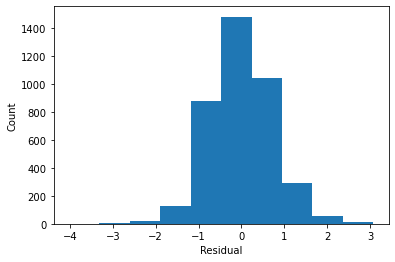

In [19]:
plt.hist((y_train-y_train_pred))
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

## Fully Bayesian Treatment

but what if the posterio(q) is not a regular distribution that we can't use formula with arguments to express them?

we introduce MCMC(Markov Chain Monte Carlo) to reconstruct(approximate) the distribution 

In [28]:
beta_init=torch.randn(12)
num_steps=5000
proposal_std=0.05
Phi=phi(X_train)

the biggest problems right now are:
(1) the bayesian method told in the class are for classification, not for 
(2) do you consider Maximumize a Posterio as a fully bayesian treatment. In other word, do we need sample from posterio or just use MAP estimation as the final value

In [29]:
beta_chain, accept=run_chain(Phi,y_train,beta_init,num_steps,proposal_std)

In [30]:
beta_chain[-5:]

[tensor([-1.7667, -1.1366, -1.0208,  0.0554, -1.8322,  6.4369, -3.0996, -1.6470,
         -3.9477, -0.4548, -0.5101, -2.8156]),
 tensor([-1.7505, -1.1542, -1.0191,  0.0629, -1.8119,  6.4976, -3.0722, -1.5542,
         -3.7974, -0.4989, -0.5794, -2.9019]),
 tensor([-1.7356, -1.1475, -1.1617,  0.0394, -1.7812,  6.4786, -3.0985, -1.5371,
         -3.7405, -0.4754, -0.6597, -2.9203]),
 tensor([-1.8076, -1.1821, -1.1684,  0.0854, -1.7819,  6.4892, -3.1742, -1.5490,
         -3.6896, -0.4320, -0.6600, -2.9695]),
 tensor([-1.8434, -1.1964, -1.0997, -0.0203, -1.7277,  6.4664, -3.2377, -1.5443,
         -3.5963, -0.4153, -0.6504, -2.9867])]

In [31]:
beta_chain[0]

tensor([-1.0437, -0.2140, -1.3093,  0.1846, -0.7005,  1.0975, -1.4201,  1.1960,
        -0.7701,  0.0459,  0.5124,  0.5212])

In [32]:
accept

5000

In [33]:
beta1

array([[ 1.36298438e+02],
       [ 5.06457657e-02],
       [-1.96341559e+00],
       [-9.16375411e-03],
       [ 7.69603869e-02],
       [-6.04146573e-01],
       [ 3.16302854e-03],
       [-4.93885998e-05],
       [-1.36198618e+02],
       [ 6.71592833e-01],
       [ 5.59628712e-01],
       [ 2.07470147e-01]])

In [34]:
beta2=beta_chain[-1].numpy().reshape(-1,1)

In [36]:
Phi @ beta_temp

array([[6.21588132],
       [6.51218672],
       [5.56793595],
       ...,
       [5.89100532],
       [6.21888268],
       [5.53883895]])

In [37]:
beta1

array([[ 1.36298438e+02],
       [ 5.06457657e-02],
       [-1.96341559e+00],
       [-9.16375411e-03],
       [ 7.69603869e-02],
       [-6.04146573e-01],
       [ 3.16302854e-03],
       [-4.93885998e-05],
       [-1.36198618e+02],
       [ 6.71592833e-01],
       [ 5.59628712e-01],
       [ 2.07470147e-01]])